In [1]:
from typing import TypedDict, Optional, Annotated, Sequence
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import os
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

/media/epein5/Data1/Langgraphs-quests/venc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.audio_retriver import get_audio_from_youtube
from utils.speech_to_text import audio_to_text
from utils.chunking import semantic_chunking
from utils.embeddings import create_embeddings, create_single_embedding
from utils.db_handler import store_video_data, retrieve_video_data
from utils.rag_search import semantic_search

In [3]:
load_dotenv()

True

In [4]:
# azure_llm = AzureChatOpenAI(
#     azure_endpoint=os.getenv("OPENAI_AZURE_ENDPOINT"),
#     api_key=os.getenv("OPENAI_AZURE_API_KEY"),
#     api_version=os.getenv("OPENAI_AZURE_API_VERSION"),
#     model=os.getenv("OPENAI_AZURE_DEPLOYMENT")
# )

In [5]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages()]
    youtube_audio: Optional[bytes]
    youtube_transcript: Optional[str]
    youtube_chunks: Optional[list]
    youtube_video_id: Optional[str]
    youtube_url: Optional[str]
    vectors: Optional[list]

In [6]:
# process_new_video("https://www.youtube.com/watch?v=dQw4w9WgXcQ","dQw4w9WgXcQ")

In [7]:
def youtube_video_id_retreiver(youtube_url: str) -> str:
    """Extract video ID from various YouTube URL formats."""
    import re
    
    # Pattern to match various YouTube URL formats
    patterns = [
        r'(?:v=|\/)([0-9A-Za-z_-]{11}).*',  # Standard and most formats
        r'(?:embed\/)([0-9A-Za-z_-]{11})',   # Embed URLs
        r'(?:watch\?v=)([0-9A-Za-z_-]{11})', # Watch URLs
        r'youtu\.be\/([0-9A-Za-z_-]{11})',   # Shortened URLs
        r'(?:shorts\/)([0-9A-Za-z_-]{11})',  # YouTube Shorts
        r'(?:live\/)([0-9A-Za-z_-]{11})',    # Live URLs
    ]
    
    for pattern in patterns:
        match = re.search(pattern, youtube_url)
        if match:
            return match.group(1)
    
    raise ValueError(f"Could not extract video ID from URL: {youtube_url}")

In [8]:
youtube_video_id_retreiver("https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2")

'dLl4PZtxia8'

In [9]:
def save_new_video_to_db(youtube_video_id: str) -> dict:
    """ Process a new YouTube video: retrieve audio, transcribe, chunk, embed, and store in DB."""
    youtube_url = f"https://www.youtube.com/watch?v={youtube_video_id}"
    audio_bytes = get_audio_from_youtube(youtube_url)
    transcript = audio_to_text(audio_bytes)
    chunks = semantic_chunking(transcript)
    vectors = create_embeddings(chunks)
    store_video_data(youtube_video_id, transcript, vectors, summary=None, chunks=chunks)
    return {
        "youtube_video_id": youtube_video_id,
        "transcript": transcript,
        "vectors": vectors,
        "chunks": chunks,
        "summary": None,
    }

In [10]:
# Tool: Agent uses this to check database (returns string to agent)
@tool
def youtube_video_data_checker(youtube_video_url: str) -> dict:
    """Check if video data exists in the database for the given YouTube video ID.
    
    Args:
        youtube_video_url (str): The URL of the YouTube video.
    """

    youtube_video_id = youtube_video_id_retreiver(youtube_video_url)
    video_data = retrieve_video_data(youtube_video_id)
    if video_data is not None:
        return {"status": "found", "video_id": youtube_video_id}
    return {"status": "not_found", "video_id": youtube_video_id}

@tool
def perform_rag_search(query: str) -> str:
    """Perform RAG search on the loaded video.
    
    Args:
        query(str): Query given by the user to that is to be used in RAG Search. 

    """
    return json.dumps({
        "query": query,
        "status": "search_requested"
    })

tools = [youtube_video_data_checker, perform_rag_search]

In [11]:
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', google_api_key=os.getenv("GOOGLE_API_KEY")).bind_tools(tools)

In [12]:
def decision_maker(state: AgentState) -> AgentState:
    '''Decides whether to process a new video or retrieve existing data based on the presence of video data in the database.'''
    
    # Check if video data is loaded in state
    has_video_data = bool(state.get("youtube_chunks") and state.get("vectors"))
    
    system_prompt_base = """You are an intelligent assistant named TubeHelper that helps users ask questions about YouTube videos.

Your role:
1. Introduce yourself as TubeHelper if this is the first message
2. Ask the user for a YouTube URL to get started
3. ONLY call the youtube_video_data_checker tool when the user provides a valid YouTube URL (contains "youtube.com" or "youtu.be")
4. If the user provides a URL, check if the video data exists using youtube_video_data_checker
5. Based on the result:
   - If the data does not exist (status: "not_found"), inform the user that you'll process the video
   - If the data exists (status: "found") and video data is now loaded, check the conversation history
6. IMPORTANT: After a video is loaded, look back at the conversation history to see if the user asked any questions
7. If you find an unanswered question about the video, immediately call perform_rag_search with that question
8. When calling perform_rag_search, extract the exact question from the user's message
9. Do NOT try to call tools with made-up or test URLs
10. Always wait for the user to provide a real YouTube URL before using tools
11. Always provide a text response to the user - never produce empty responses

Be conversational, helpful, and always respond with meaningful text."""
    
    if has_video_data:
        system_prompt_base += f"""

IMPORTANT: Video data is currently loaded (ID: {state.get('youtube_video_id')}). 
Check if there are any unanswered questions in the conversation history and use perform_rag_search to answer them."""
    
    system_prompt = SystemMessage(content=system_prompt_base)
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages":[response]}

In [71]:
def routers(state:AgentState):
    import json
    messages = state["messages"]
    ai_message = messages[-1] if messages else None
    
    print(f"\n=== ROUTER CALLED ===")
    print(f"Last message type: {type(ai_message).__name__ if ai_message else None}")
    
    # If AI message has tool calls, route to tool handler (even if content is empty)
    if ai_message and hasattr(ai_message, 'tool_calls') and ai_message.tool_calls:
        print(f"Routing to tool_handler (AI has tool calls)")
        return "tool_handler"
    
    # Check for empty or None response from LLM (only if no tool calls)
    if ai_message and hasattr(ai_message, 'content'):
        if not ai_message.content or ai_message.content.strip() == "":
            print(f"Routing to END (empty AI response)")
            return END
    
    # Look for the most recent tool message in the conversation
    tool_message = None
    for i in range(len(messages) - 1, -1, -1):
        if hasattr(messages[i], 'name'):  # ToolMessage has a 'name' attribute
            tool_message = messages[i]
            print(f"Found tool message at index {i}: {tool_message.name}")
            break
    
    if not tool_message:
        print(f"Routing to END (no tool message found)")
        return END  # End the conversation if no tool was executed
    
    tool_name = tool_message.name
    
    # Parse the tool result - handle both string and dict content
    content = None
    try:
        if isinstance(tool_message.content, str):
            # Try to parse JSON string
            try:
                content = json.loads(tool_message.content)
                print(f"Parsed tool content: {content}")
            except json.JSONDecodeError:
                # If it's not JSON, treat it as plain text
                content = tool_message.content
        else:
            content = tool_message.content
    except (TypeError, AttributeError):
        print(f"Routing to END (couldn't parse tool content)")
        return END
    
    # Route based on tool name and result
    if tool_name == "youtube_video_data_checker":
        # content should be a dict with "status" key
        if isinstance(content, dict):
            status = content.get("status")
            if status == "not_found":
                print(f"Routing to process_new_video")
                return "process_new_video"
            elif status == "found":
                print(f"Routing to process_existing_video")
                return "process_existing_video"
    
    elif tool_name == "perform_rag_search":
        print(f"Routing to handle_rag_search")
        return "handle_rag_search"
    
    print(f"Routing to END (default)")
    return END

In [78]:
import json

def update_state_only(state:AgentState) -> AgentState:
    print(f"DEBUG update_state_only: Starting")
    messages = state["messages"]
    
    # Find the most recent youtube_video_data_checker tool result
    for i in range(len(messages) - 1, -1, -1):
        if hasattr(messages[i], 'name') and messages[i].name == 'youtube_video_data_checker':
            print(f"DEBUG: Found youtube_video_data_checker at index {i}")
            try:
                content = json.loads(messages[i].content)
                video_id = content.get("video_id")
                if video_id:
                    state["youtube_video_id"] = video_id
                    print(f"DEBUG: Set video_id to {video_id}")
                    break
            except (json.JSONDecodeError, TypeError) as e:
                print(f"DEBUG: Error parsing tool message: {e}")
                pass
    
    youtube_video_id = state.get("youtube_video_id")
    print(f"DEBUG: youtube_video_id = {youtube_video_id}")
    if youtube_video_id:
        response = retrieve_video_data(youtube_video_id)
        print(f"DEBUG: DB response keys: {response.keys() if response else None}")
        if response:
            state["youtube_transcript"] = response["full_transcription"]
            state["youtube_chunks"] = response["chunks"]
            state["vectors"] = response["vectors"]
            print(f"DEBUG: Loaded {len(state['youtube_chunks'])} chunks and {len(state['vectors'])} vectors")
    return state

def process_new_video_and_update_state(state:AgentState) -> AgentState:
    messages = state["messages"]
    
    # Find the most recent youtube_video_data_checker tool result
    for i in range(len(messages) - 1, -1, -1):
        if hasattr(messages[i], 'name') and messages[i].name == 'youtube_video_data_checker':
            try:
                content = json.loads(messages[i].content)
                video_id = content.get("video_id")
                if video_id:
                    state["youtube_video_id"] = video_id
                    break
            except (json.JSONDecodeError, TypeError):
                pass
    
    youtube_video_id = state.get("youtube_video_id")
    if youtube_video_id:
        response = save_new_video_to_db(youtube_video_id)
        state["youtube_transcript"] = response["transcript"]
        state["youtube_chunks"] = response["chunks"]
        state["vectors"] = response["vectors"]
    return state

def handle_rag_search(state: AgentState) -> AgentState:
    """Custom handler to perform actual RAG search since tools can't access state."""
    messages = state["messages"]
    
    print(f"DEBUG: handle_rag_search called")
    print(f"DEBUG: Has chunks: {bool(state.get('youtube_chunks'))}")
    print(f"DEBUG: Has vectors: {bool(state.get('vectors'))}")
    
    # Find the last tool result from perform_rag_search
    for i in range(len(messages) - 1, -1, -1):
        if hasattr(messages[i], 'name') and messages[i].name == 'perform_rag_search':
            print(f"DEBUG: Found perform_rag_search at index {i}")
            try:
                tool_result = json.loads(messages[i].content)
                query = tool_result.get("query")
                print(f"DEBUG: Query extracted: {query}")
                
                if query and state.get("youtube_chunks") and state.get("vectors"):
                    # Perform the actual RAG search
                    search_results = semantic_search(query, state["vectors"], state["youtube_chunks"])
                    response_text = "Based on the video, here are the most relevant sections:\n\n" + "\n".join(search_results)
                    print(f"DEBUG: RAG Search completed. Results length: {len(response_text)}")
                    
                    # Add AI response with the RAG results
                    ai_response = AIMessage(content=response_text)
                    state["messages"].append(ai_response)
                else:
                    print(f"DEBUG: Missing required data - query: {bool(query)}, chunks: {bool(state.get('youtube_chunks'))}, vectors: {bool(state.get('vectors'))}")
            except (json.JSONDecodeError, TypeError, AttributeError) as e:
                print(f"DEBUG: Error in handle_rag_search: {e}")
                pass
            break
    
    return state

In [79]:
graph = StateGraph(AgentState)

In [80]:
graph.add_node("decision_maker",decision_maker)
graph.add_node("update_state_only",update_state_only)
graph.add_node("process_new_video_and_update_state",process_new_video_and_update_state)
graph.add_node("handle_rag_search",handle_rag_search)

In [81]:
tool_node = ToolNode(tools)
graph.add_node("tool_node", tool_node)

In [82]:
graph.set_entry_point("decision_maker")
graph.add_conditional_edges(
    "decision_maker",
    routers,
    {
        "tool_handler": "tool_node",
        "process_new_video": "process_new_video_and_update_state",
        "process_existing_video": "update_state_only",
        "handle_rag_search": "handle_rag_search",
        END: END,
    }
)
# After tool execution, route based on which tool was executed
graph.add_conditional_edges(
    "tool_node",
    routers,
    {
        "tool_handler": "tool_node",  # shouldn't happen but just in case
        "process_new_video": "process_new_video_and_update_state",
        "process_existing_video": "update_state_only",
        "handle_rag_search": "handle_rag_search",
        END: "decision_maker",  # If no special routing, go back to decision_maker
    }
)
graph.add_edge("update_state_only", "decision_maker")
graph.add_edge("process_new_video_and_update_state", "decision_maker")
graph.add_edge("handle_rag_search", "decision_maker")

In [83]:
app = graph.compile()

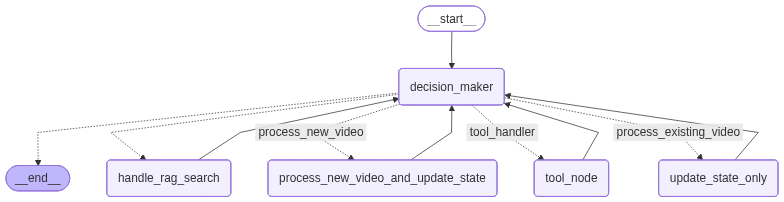

In [20]:
app

In [21]:
result = app.invoke({"messages":[HumanMessage(content="Hey, i wanted to saerch for this viddeo: https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2. Waht does the song say regarding HOtel Calofornia")]})

In [22]:
result

{'messages': [HumanMessage(content='Hey, i wanted to saerch for this viddeo: https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2. Waht does the song say regarding HOtel Calofornia', additional_kwargs={}, response_metadata={}, id='6b6a636e-84d1-45e7-ada5-d2eaa562e98b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'youtube_video_data_checker', 'arguments': '{"youtube_video_url": "https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--7139368b-be4a-49aa-8c70-e67921b53f7d-0', tool_calls=[{'name': 'youtube_video_data_checker', 'args': {'youtube_video_url': 'https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2'}, 'id': 'f87d4c21-7c0b-404e-94df-1c1becdb5345', 'type': 'tool_call'}], usage_metadata={'input_

In [23]:
retrieve_video_data("dLl4PZtxia8")

{'primary_key': 'dLl4PZtxia8',
 'full_transcription': '♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪',
 'summary': None,
 'chunks': ['♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪'],
 'vectors': [[-0.004843701608479023,
   -0.029467791318893433,
   0.027233770117163658,
   -0.03531879559159279,
   -0.018084926530718803,
   0.00446471618488431,
   -0.011070367880165577,
   -0.0332709439098835,
   -0.01029245089739561,
   -0.012273813597857952,
   0.030531611293554306,
   0.017513122409582138,
   0.015957288444042206,
   -0.019308317452669144,
   0.013563694432377815,
   0.01076452061533928,
   0.04340382292866707,
   0.003982672933489084,
   0.01537218689918518,
   -0.024893369525671005,
   0.00013547072012443095,
   0.006881580222398043,
   0.0032213774975389242,
  

In [84]:
# Test the improved flow
result2 = app.invoke({"messages":[HumanMessage(content="Hey, I wanted to search for this video: https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2. What does the song say regarding Hotel California?")]})


=== ROUTER CALLED ===
Last message type: AIMessage
Routing to tool_handler (AI has tool calls)

=== ROUTER CALLED ===
Last message type: ToolMessage
Found tool message at index 2: youtube_video_data_checker
Parsed tool content: {'status': 'found', 'video_id': 'dLl4PZtxia8'}
Routing to process_existing_video
DEBUG update_state_only: Starting
DEBUG: Found youtube_video_data_checker at index 2
DEBUG: Set video_id to dLl4PZtxia8
DEBUG: youtube_video_id = dLl4PZtxia8
DEBUG: DB response keys: dict_keys(['primary_key', 'full_transcription', 'summary', 'chunks', 'vectors', 'created_at', 'updated_at'])
DEBUG: Loaded 1 chunks and 1 vectors

=== ROUTER CALLED ===
Last message type: AIMessage
Routing to tool_handler (AI has tool calls)

=== ROUTER CALLED ===
Last message type: ToolMessage
Found tool message at index 4: perform_rag_search
Parsed tool content: {'query': 'What does the song say regarding Hotel California?', 'status': 'search_requested'}
Routing to handle_rag_search
DEBUG: handle_rag

In [31]:
# Print the final message to see the result
result2['messages'][-1].content

''

In [69]:
# Debug: print all messages to see the flow
for i, msg in enumerate(result2['messages']):
    print(f"\n--- Message {i} ---")
    print(f"Type: {type(msg).__name__}")
    if hasattr(msg, 'content'):
        print(f"Content: {msg.content[:200] if msg.content else 'EMPTY'}")
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print(f"Tool Calls: {msg.tool_calls}")


--- Message 0 ---
Type: HumanMessage
Content: Hey, I wanted to search for this video: https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2. What does the song say regarding Hotel California?

--- Message 1 ---
Type: AIMessage
Content: EMPTY
Tool Calls: [{'name': 'youtube_video_data_checker', 'args': {'youtube_video_url': 'https://www.youtube.com/watch?v=dLl4PZtxia8&list=RDQ3TI27IN7X0&index=2'}, 'id': '821b0ffd-5fec-4a10-b5da-217d7a8e0265', 'type': 'tool_call'}]

--- Message 2 ---
Type: ToolMessage
Content: {"status": "found", "video_id": "dLl4PZtxia8"}

--- Message 3 ---
Type: AIMessage
Content: I see that you've previously asked the question, "What does the song say regarding Hotel California?". I'll perform a search to answer that for you.
Tool Calls: [{'name': 'perform_rag_search', 'args': {'query': 'What does the song say regarding Hotel California?'}, 'id': '9995bc6e-5eb6-487b-b05b-68b8706f5bb4', 'type': 'tool_call'}]

--- Message 4 ---
Type: ToolMessage
Content

In [85]:
# Check the last message
print(result2['messages'][-1].content)

 ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪
[Music]
so
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music]
you
[Music]
so
[Music

In [70]:
# Check state values
print("State keys:", result2.keys())
print("Has youtube_video_id:", result2.get("youtube_video_id"))
print("Has youtube_chunks:", bool(result2.get("youtube_chunks")))
print("Has vectors:", bool(result2.get("vectors")))

State keys: dict_keys(['messages'])
Has youtube_video_id: None
Has youtube_chunks: False
Has vectors: False


In [87]:
# Print just the RAG answer (should start with "Based on the video")
for msg in reversed(result2['messages']):
    if hasattr(msg, 'content') and msg.content and msg.content.startswith("Based on the video"):
        print("=== RAG Answer ===")
        print(msg.content)
        break

=== RAG Answer ===
Based on the video, here are the most relevant sections:

♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪ ♪
